# Packages

In [ ]:
import os
import json
import time
from pathlib import Path
from datetime import datetime
import ast

import pandas as pd
import geopandas as gpd
import numpy as np

# Loading data

In [118]:
PROJECT_ROOT = Path.cwd().resolve().parent
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
RAW_DIR = DATA_DIR / "raw"

In [192]:
football = pd.read_csv(RAW_DIR / "football.csv")

# Exporatory Data Analysis

In [173]:
football.columns

Index(['id', 'index', 'match_id', 'period', 'timestamp', 'team', 'team_id',
       'player', 'player_id', 'position', 'play_pattern', 'type',
       'under_pressure', 'shot_deflected', 'shot_open_goal', 'shot_type',
       'shot_statsbomb_xg', 'shot_freeze_frame', 'location', 'shot_outcome',
       'shot_body_part'],
      dtype='object')

In [174]:
football.groupby(["shot_type"])["shot_outcome"].count()

shot_type
Corner          13
Free Kick     2126
Open Play    43137
Penalty        496
Name: shot_outcome, dtype: int64

Are we going to look at all the periods? Overtime and also penalty kick?

In [175]:
football["period"].value_counts().sort_index()

period
1    20824
2    24926
3        8
4        5
5        9
Name: count, dtype: int64

I am gonna transform shot outcome column into a 0 and 1 column

In [176]:
football["shot_outcome"].unique().tolist()

['Off T',
 'Goal',
 'Blocked',
 'Saved',
 'Wayward',
 'Post',
 'Saved Off Target',
 'Saved to Post']

I will transform timestamp into a minute ceil column (e.g., 4:32 -> 5th minute)

In [177]:
football["timestamp"].unique()

array(['00:04:21.052', '00:06:27.395', '00:08:16.762', ...,
       '00:45:24.473', '00:45:25.517', '00:47:47.998'],
      shape=(45397,), dtype=object)

I will transform location to a x and y column by making it a list first

In [198]:
football["location"].head()

0    [108.1, 31.2]
1    [110.9, 42.6]
2    [117.9, 29.1]
3    [101.8, 27.6]
4    [109.3, 26.5]
Name: location, dtype: object

<Axes: xlabel='shot_body_part'>

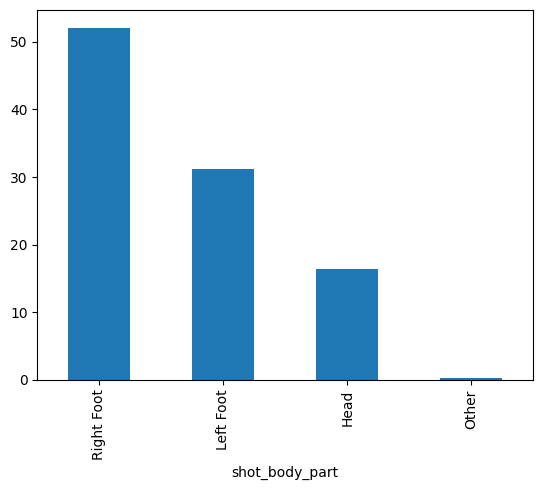

In [199]:
(football["shot_body_part"].value_counts(normalize=True) * 100).plot(kind='bar')

There is no freeze frame data for penalty kicks which makes sense

In [218]:
football[football["shot_freeze_frame"].isna()]["shot_type"].value_counts()

shot_type
Penalty    444
Name: count, dtype: int64

In [280]:
football[(football["period"] != 1) & (football["period"] != 2)].head(2)

,id,index,match_id,period,timestamp,team,team_id,player,player_id,position,...,shot_deflected,shot_open_goal,shot_type,shot_statsbomb_xg,shot_freeze_frame,location,shot_outcome,shot_body_part,x,y
7862,4ffa553b-8cc4-4af1-8090-8899931354c5,3674,18243,3,00:01:28.289,Real Madrid,220,Carlos Henrique Casimiro,5539.0,Center Defensive Midfield,...,NaN,NaN,Open Play,0.018604,"[{'location': [95.0, 8.0], 'player': {'id': 55...","[86.0, 39.0]",Saved,Right Foot,86.0,39.0
7863,f4d91657-04b1-4a32-8977-c9a8acdf7f69,3719,18243,3,00:02:46.572,Real Madrid,220,Gareth Frank Bale,6399.0,Left Wing,...,NaN,NaN,Open Play,0.007215,"[{'location': [92.0, 25.0], 'player': {'id': 6...","[90.0, 22.0]",Off T,Left Foot,90.0,22.0


Distance from goal

In [282]:
football.columns

Index(['id', 'index', 'match_id', 'period', 'timestamp', 'team', 'team_id',
       'player', 'player_id', 'position', 'play_pattern', 'type',
       'under_pressure', 'shot_deflected', 'shot_open_goal', 'shot_type',
       'shot_statsbomb_xg', 'shot_freeze_frame', 'location', 'shot_outcome',
       'shot_body_part', 'x', 'y'],
      dtype='object')

# Processing Data

In [ ]:
def process_shot_outcome(df):
    outcome_mapping = {
        'Off T': 0,
        'Goal': 1,
        'Blocked': 0,
        'Saved': 0,
        'Wayward': 0,
        'Post': 0,
        'Saved Off Target': 0,
        'Saved to Post': 0
    }

    df['shot_outcome_encoded'] = df['shot_outcome'].map(outcome_mapping)
    return df

def process_shot_body_part(df):

    dummies = pd.get_dummies(df['shot_body_part'], prefix='body_part', drop_first=False, dtype=int)
    dummies.columns = dummies.columns.str.lower().str.replace(" ", "_")

    df = pd.concat([df, dummies], axis=1)
    return df

def process_timestamp(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%H:%M:%S.%f')
    df['time_only'] = df['timestamp'].dt.time
    df['hour'] = df['timestamp'].dt.hour # maybe remove?
    df['minute'] = df['timestamp'].dt.minute # maybe remove?
    df['second'] = df['timestamp'].dt.second # maybe remove?
    df['minute_ceil'] = df['timestamp'].dt.ceil('min').dt.minute
    return df

def process_location(df):
    df["location"] = df['location'].apply(ast.literal_eval)
    df[["x", "y"]] = pd.DataFrame(df["location"].tolist(), index=df.index)
    return df

def distance_from_goal(df, home):
    if home:
        df['distance_from_goal_center'] = np.sqrt((120 - df['x'])**2 + (40 - df['y'])**2) # need to double check
        df['distance_from_goal_left_post'] = np.sqrt((120 - df['x'])**2 + (36 - df['y'])**2)
        df['distance_from_goal_right_post'] = np.sqrt((120 - df['x'])**2 + (44 - df['y'])**2)
    else:
        df['distance_from_goal_center'] = np.sqrt((0 - df['x'])**2 + (40 - df['y'])**2)
        df['distance_from_goal_left_post'] = np.sqrt((0 - df['x'])**2 + (36 - df['y'])**2)
        df['distance_from_goal_right_post'] = np.sqrt((0 - df['x'])**2 + (44 - df['y'])**2)
    return df

In [143]:
football = process_shot_outcome(football)
football = process_timestamp(football)